In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.arima_model import ARMA

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
file95 = "D:\\matst\\sem6\\ZRP\\VaR95.csv"
file99 = "D:\\matst\\sem6\\ZRP\\VaR99.csv"
var95 = pd.read_csv(file95, header=None)
var99 = pd.read_csv(file99, header=None)

len(var95[0])



339

In [4]:
file = "D:\\matst\\sem6\\ZRP\\Data_ZRP.csv" 
df = pd.read_csv(file, parse_dates = ['Data'], index_col = 'Data')
df['Coal_pct'] = df.Coal.pct_change().mul(100) 
df.head()

,Coal,Natural_Gas,Coal_pct
Data,,,
2009-12-31,83.60,5.666,NaN
2010-01-04,88.65,5.720,6.040670
2010-01-05,93.00,5.783,4.906937
2010-01-06,93.30,5.638,0.322581
2010-01-07,96.65,5.941,3.590568


In [5]:
historic = df.Coal_pct.loc['2015':'2016'] 
actual = df.Coal_pct.loc['01-04-2017':]

In [6]:
data = df.Coal_pct.loc['2015':]
data = data[2:]
type(data)

pandas.core.series.Series

In [7]:
#parametric
def Par_Norm(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined parametric method with normal distribution
    """
    mean = data.mean()
    std = data.std()
    return(stats.norm.ppf(level, loc = mean, scale = std))
#historical
def Hist(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined historical method 
    """
    return(np.percentile(data.values, level*100))
#historical weighted
def His_weight(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined historical weighted method 
    """
    data = pd.DataFrame(data)
    N = len(data) - 1
    lda = 0.92
    S = lda*(1-lda**N)/(1-lda)
    w1 = 1/(1+S)
    data['weighted'] = w1*np.cumprod(np.concatenate([np.array([1]), lda*np.ones(N)]))[::-1]
    temp = data.sort_values('Coal_pct')
    temp['pr'] = temp['weighted'].cumsum()
    result = temp[temp['pr'] >= level].iloc[0]['Coal_pct']
    return(result)
#Monte Carlo
def mc(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined Monte Carlo method with MA(1)
    """
    model = ARMA(data.values, order = (0,1)).fit()
    mu, theta = model.params
    random_sample = np.random.normal(loc = np.mean(model.resid), scale = np.std(model.resid), size = 10000)
    predictions = mu + random_sample + theta*model.resid[-1]
    return np.percentile(predictions, level*100)

In [8]:
def Var_vector(data, Varfunction, alpha, year = 2, beg_index = 0):
    """ 
    input
    data: vector of portfolio returns
    Varfunction: function determining value at risk 
    alpha: statistical significance
    output
    var_vector: forecast of VaR for each day
    data[2*year:] : actual value of portfolio returns
    """ 
    data_len = len(data) 
    var_len = data_len-year*365-beg_index #range - 2 years
    var_vector = np.empty(var_len, float)
    for i in range(var_len): 
        var_vector[i] = Varfunction( data[beg_index+i : (year*365+i)], (1-alpha) )
    return(var_vector, data[beg_index+year*365:])
        
    

In [25]:
def Var_window(data, Varfunction, alpha, w_length = 365):
    """ 
    input
    data: vector of portfolio returns
    Varfunction: function determining value at risk 
    alpha: statistical significance
    output
    var_vector: forecast of VaR for each day
    data[2*year:] : actual value of portfolio returns
    """ 
    data_len = len(data) 
    var_len = data_len-w_length  #range - 2 years
    var_vector = np.empty(var_len, float)
    for i in range(var_len): 
        var_vector[i] = Varfunction( data[i : (w_length+i)], (1-alpha) )
    return(var_vector, data[w_length:])
        
    

In [27]:
def Backtesting(actual, forecast, alpha, model=None, test="Christoffersen"):
    """ 
    input
    actual: portfolio returns
    forecast: Value at risk -dictionary or scalar
    alpha: statistical significance
    output:
    dataframe: columns: model, Statistic, alpha,  p-value, test outcome 
    """
    results = []
    if type(forecast) == dict:
        for key in forecast:
            I = (actual > forecast[key])*1
            con = I[1:]-I[:-1] 
            n01, n10 = (con == 1).sum(), (con == -1).sum() 
            n11, n00 = (I[1:][con == 0] == 1).sum(), (I[1:][con == 0] == 0).sum()
            p0 = n01/(n00 + n01)         
            p1 = n11/(n10 + n11)
            p = (n01 + n11)/(n00 + n01 + n10 + n11)
            # indepedence Christoffersen
            if test == "Christoffersen":
                LR = -2*np.log((1 - p)**(n00+n10)*p**(n01 + n11)/((1-p0)**(n00)*p0**n01*(1-p1)**n10*p1**n11))
                chi = 1 - stats.chi2.cdf(LR,  df=1)
                if chi < alpha:
                    ans = "reject"
                else:
                    ans = "accept"
            #kupiec
            if test == "Kupiec":
                i = I.sum()
                proc = i/len(I)
                Lpi = (1-i/len(I))**(len(I)-i)*(i/len(I))**i
                pk = alpha
                Lp = (1-pk)**(len(I)-i)*pk**i
                LR = -2*np.log(Lp/Lpi)
                chi = 1 - stats.chi2.cdf(LR,df=1)

                if chi< alpha:
                    ans = "reject"
                else:
                    ans = "accept"
            frame = {"Model": key,"alpha": alpha, "Statistic": LR, "p-value": chi, "result": ans, "percentage of exceedances":str(p*100)+"%"}
            results.append(frame)
            return(results)
            
    else:
        I = (actual > forecast)*1 
        con = I[1:]-I[:-1] 
        n01, n10 = (con == 1).sum(), (con == -1).sum() 
        n11, n00 = (I[1:][con == 0] == 1).sum(), (I[1:][con == 0] == 0).sum()
        p0 = n01/(n00 + n01)         
        p1 = n11/(n10 + n11)
        p = (n01 + n11)/(n00 + n01 + n10 + n11)
        if test == "Christoffersen":
                LR = -2*np.log((1 - p)**(n00+n10)*p**(n01 + n11)/((1-p0)**(n00)*p0**n01*(1-p1)**n10*p1**n11))
                chi = 1 - stats.chi2.cdf(LR,  df=1)
                if chi < alpha:
                    ans = "reject"
                else:
                    ans = "accept"
            #kupiec
        elif test == "Kupiec":
                i = I.sum()
                proc = i/len(I)
                Lpi = (1-i/len(I))**(len(I)-i)*(i/len(I))**i
                pk = alpha
                Lp = (1-pk)**(len(I)-i)*pk**i
                LR = -2*np.log(Lp/Lpi)
                chi = 1 - stats.chi2.cdf(LR,df=1)

                if chi< alpha:
                    ans = "reject"
                else:
                    ans = "accept"
    
        if model is not None:
            name = model
        else:
            name = " - "
        return(p*100, chi)
        #results = {"Model": [name],"alpha": [alpha],"Statistic": [LR], "p-value": [chi], "result": [ans], "percentage of exceedances":[str(p*100)]}
    #results = pd.DataFrame(data=results)
    #return (results)

In [10]:
Pvar5, days = Var_vector(data, Par_Norm ,0.05)
Hvar5, Hdays =  Var_vector(data, Hist ,0.05)
HWvar5, HWdays = Var_vector(data, His_weight ,0.05)
Mvar5, Mdays = Var_vector(data, mc ,0.05)

forecast5 = {"parametric": Pvar5, "historical": Hvar5,"historical weighted": HWvar5,"Monte Carlo": Mvar5}
Backtesting(days.values, forecast5, 0.05, test="Christoffersen")


,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,parametric,0.150156,0.05,0.698387,1.4792899408284024%,accept
1,Monte Carlo,0.150156,0.05,0.698387,1.4792899408284024%,accept
2,historical,0.150156,0.05,0.698387,1.4792899408284024%,accept
3,historical weighted,0.013748,0.05,0.906660,7.988165680473373%,accept


In [37]:
k = 348
p_val = np.empty(k//4,float)
exced = np.empty(k//4,float)
alpha = 0.05
for i in range(k,2*k,4):
    var, days = Var_window(data, mc, alpha, w_length = i)
    exced[(i-k)//4], p_val[(i-k)//4] = Backtesting(days.values, var, alpha, test="Kupiec", model = "hist_weight")


In [45]:
k = 348
p_val9 = np.empty(k//4,float)
exced9 = np.empty(k//4,float)
alpha9 = 0.01
for i in range(k,2*k,4):
    var9, days9 = Var_window(data, mc, alpha9, w_length = i)
    exced9[(i-k)//4], p_val9[(i-k)//4] = Backtesting(days9.values, var9, alpha9, test="Kupiec", model = "hist_weight")


In [35]:
for i in range(0,5,2):
    print(i)

0
2
4


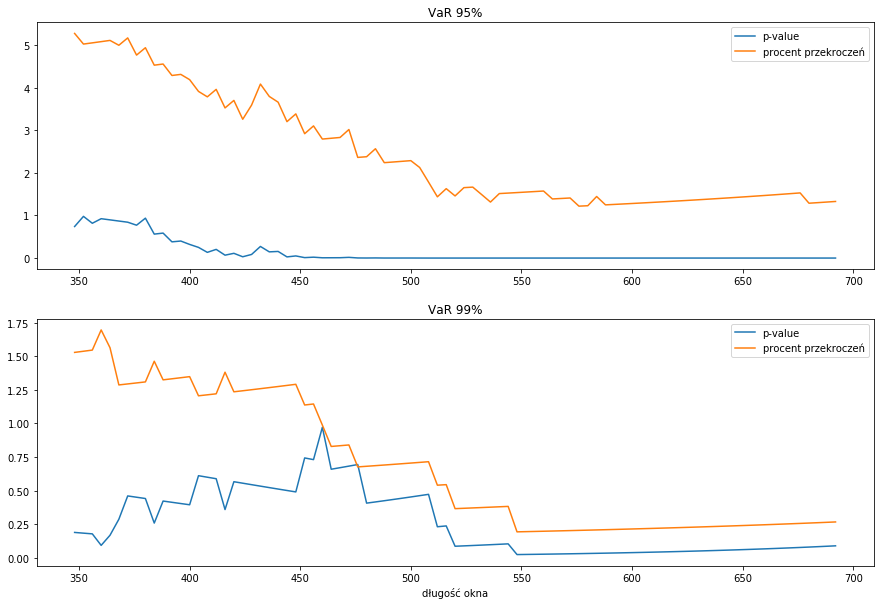

In [60]:
plt.subplots(2,1,figsize=(15,10))
plt.subplot(211)
plt.plot(range(k,2*k,4),p_val,label="p-value")
plt.plot(range(k,2*k,4),exced,label="procent przekroczeń")
plt.title("VaR 95%")
plt.legend()
plt.subplot(212)
plt.plot(range(k,2*k,4),p_val9,label="p-value")
plt.plot(range(k,2*k,4),exced9,label="procent przekroczeń")
plt.xlabel("długość okna")
plt.title("VaR 99%")
plt.legend()
plt.savefig(file95.replace('.csv','okna.png'))
plt.show()

In [11]:
Backtesting(days.values, forecast5, 0.05, test="Kupiec")

,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,parametric,12.129733,0.05,0.000496,1.4792899408284024%,reject
1,Monte Carlo,12.129733,0.05,0.000496,1.4792899408284024%,reject
2,historical,12.129733,0.05,0.000496,1.4792899408284024%,reject
3,historical weighted,5.357666,0.05,0.020631,7.988165680473373%,reject


In [12]:
Pvar9, Pdays = Var_vector(data, Par_Norm ,0.01)
Hvar9, Hdays =  Var_vector(data, Hist ,0.01)
HWvar9, HWdays = Var_vector(data, His_weight ,0.01)
Mvar9, Mdays = Var_vector(data, mc ,0.01)
forecast9= {"parametric": Pvar9, "historical": Hvar9,"historical weighted": HWvar9, "Monte Carlo":Mvar9}
Backtesting(days.values, forecast9, 0.01, test="Christoffersen")

,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,parametric,0.005935,0.01,0.938594,0.2958579881656805%,accept
1,Monte Carlo,0.005935,0.01,0.938594,0.2958579881656805%,accept
2,historical,0.005935,0.01,0.938594,0.2958579881656805%,accept
3,historical weighted,0.617475,0.01,0.431987,3.5502958579881656%,accept


In [13]:
Backtesting(days.values, forecast9, 0.01, test="Kupiec")

,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,parametric,2.355320,0.01,0.124856,0.2958579881656805%,accept
1,Monte Carlo,2.355320,0.01,0.124856,0.2958579881656805%,accept
2,historical,2.355320,0.01,0.124856,0.2958579881656805%,accept
3,historical weighted,13.340643,0.01,0.000260,3.5502958579881656%,reject


Przesunięcie okna 

In [14]:
Pvar5_mov, days_mov = Var_vector(data, Par_Norm ,0.05, year =1 , beg_index = 200)
Hvar5_mov, Hdays_mov =  Var_vector(data, Hist ,0.05, year =1 , beg_index = 200)
HWvar5_mov, HWdays_mov = Var_vector(data, His_weight ,0.05, year =1 , beg_index = 200)
Mvar5_mov, Mdays_mov = Var_vector(data, mc ,0.05, year =1 , beg_index = 200)

forecast5_mov = {"parametric": Pvar5_mov, "historical": Hvar5_mov,"historical weighted": HWvar5_mov,"Monte Carlo": Mvar5_mov}
Backtesting(days_mov.values, forecast5_mov, 0.05, test="Christoffersen")


,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,parametric,0.689877,0.05,0.406206,2.584493041749503%,accept
1,Monte Carlo,0.546778,0.05,0.459637,2.982107355864811%,accept
2,historical,1.051524,0.05,0.305156,3.180914512922465%,accept
3,historical weighted,2.742803,0.05,0.097693,5.7654075546719685%,accept


In [15]:
Backtesting(days_mov.values, forecast5_mov, 0.05, test="Kupiec")


,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,parametric,7.498993,0.05,0.006173,2.584493041749503%,reject
1,Monte Carlo,5.051953,0.05,0.024598,2.982107355864811%,reject
2,historical,4.039485,0.05,0.044447,3.180914512922465%,reject
3,historical weighted,0.576445,0.05,0.447709,5.7654075546719685%,accept


In [16]:
Pvar9_mov, days_mov = Var_vector(data, Par_Norm ,0.01, year =1 , beg_index = 200)
Hvar9_mov, Hdays_mov =  Var_vector(data, Hist ,0.01, year =1 , beg_index = 200)
HWvar9_mov, HWdays_mov = Var_vector(data, His_weight ,0.01, year =1 , beg_index = 200)
Mvar9_mov, Mdays_mov = Var_vector(data, mc ,0.01, year =1 , beg_index = 200)

forecast9_mov = {"parametric": Pvar9_mov, "historical": Hvar9_mov,"historical weighted": HWvar9_mov,"Monte Carlo": Mvar9_mov}
Backtesting(days_mov.values, forecast9_mov, 0.01, test="Christoffersen")


,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,parametric,0.036000,0.01,0.849515,0.5964214711729622%,accept
1,Monte Carlo,0.064129,0.01,0.800085,0.7952286282306162%,accept
2,historical,0.036000,0.01,0.849515,0.5964214711729622%,accept
3,historical weighted,0.405707,0.01,0.524156,1.9880715705765408%,accept


In [17]:
Backtesting(days_mov.values, forecast9_mov, 0.01, test="Kupiec")

,Model,Statistic,alpha,p-value,percentage of exceedances,result
0,parametric,0.975566,0.01,0.323296,0.5964214711729622%,accept
1,Monte Carlo,0.233272,0.01,0.629108,0.7952286282306162%,accept
2,historical,0.975566,0.01,0.323296,0.5964214711729622%,accept
3,historical weighted,3.833050,0.01,0.050251,1.9880715705765408%,accept


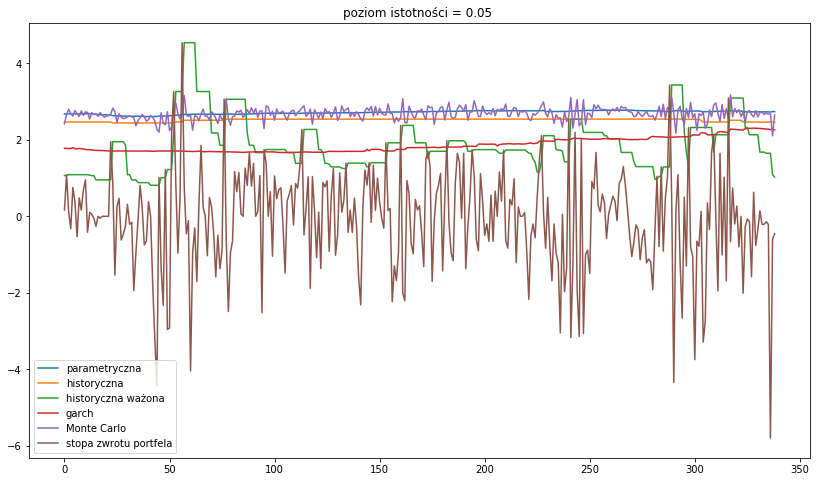

In [23]:
#plt.style.use('ggplot')
plt.figure(figsize = (14,8))
plt.plot(Pvar5, label = "parametryczna")
plt.plot(Hvar5, label = "historyczna")
plt.plot(HWvar5, label = "historyczna ważona")
plt.plot(var95, label = "garch" )
plt.plot(Mvar5, label = "Monte Carlo")
plt.plot(days.values, label = "stopa zwrotu portfela" )

plt.legend(loc = 3)
plt.title("poziom istotności = 0.05 ")
plt.savefig(file95.replace('.csv','.png'))
plt.show()

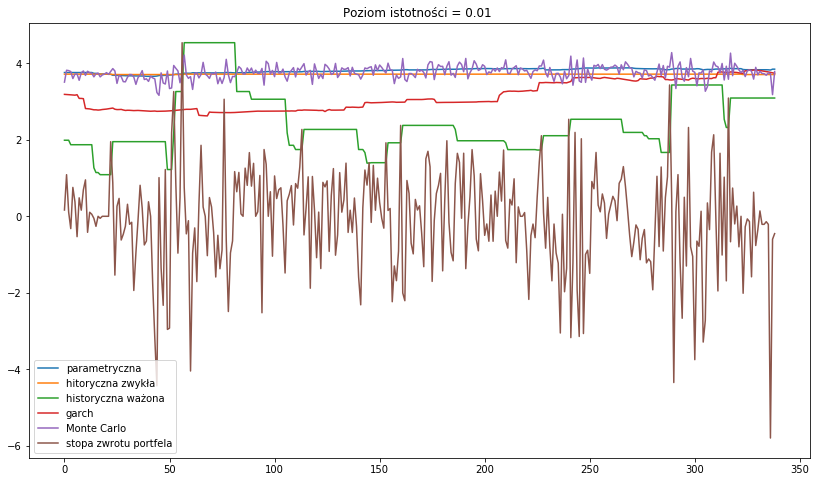

In [24]:
#plt.style.use('ggplot')
plt.figure(figsize = (14,8))
plt.plot(Pvar9, label = "parametryczna")
plt.plot(Hvar9, label = "hitoryczna zwykła")
plt.plot(HWvar9, label = "historyczna ważona")
plt.plot(var99, label = "garch" )
plt.plot(Mvar9, label = "Monte Carlo")
plt.plot(days.values, label = "stopa zwrotu portfela" )
plt.legend(loc = 3)
plt.title("Poziom istotności = 0.01 ")
plt.savefig(file99.replace('.csv','.png'))
plt.show()

In [59]:
from arch import arch_model
garch11 = arch_model(actual, p=1, q=1)
res = garch11.fit(update_freq=10)

print(res)

Iteration:     10,   Func. Count:     72,   Neg. LLF: 917.8626370219456
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 917.8625888070746
            Iterations: 13
            Function evaluations: 90
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:               Coal_pct   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -917.863
Distribution:                  Normal   AIC:                           1843.73
Method:            Maximum Likelihood   BIC:                           1861.09
                                        No. Observations:                  568
Date:                Sun, May 26 2019   Df Residuals:                      564
Time:                        14:06:06   Df Model:                            4
       